In [2]:
import sys, os 
os.environ['KERAS_BACKEND'] = "tensorflow"

import keras
from keras import backend as K
#from keras import layers
from keras.layers import Input, Dense, Flatten, Conv2D, Reshape, Conv2DTranspose, Lambda
#from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras.layers import Input, Dense
from keras.utils import np_utils
from keras.models import load_model

from keras.callbacks import ModelCheckpoint


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from livelossplot import PlotLossesKeras
from keras.utils.data_utils import get_file

%matplotlib inline

Using TensorFlow backend.


In [3]:
#para melhor gestão memória GPU por parte do tensorflow
import tensorflow.compat.v1 as tf     

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica


11493376/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)


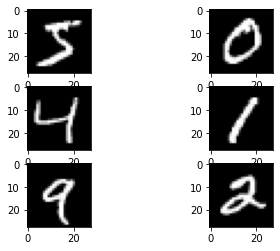

shape[0]:  60000
shape antes:  (60000, 28, 28)
shape depois:  (60000, 28, 28, 1)
(10000,)
[7 2 1 ... 4 5 6]


In [4]:
def load_mnist_dataset(path='mnist.npz'):
    path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist(X_train):
    #(X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap='gray')
    plt.subplot(322)
    plt.imshow(X_train[1], cmap='gray')
    plt.subplot(323)
    plt.imshow(X_train[2], cmap='gray')
    plt.subplot(324)
    plt.imshow(X_train[3], cmap='gray')
    plt.subplot(325)
    plt.imshow(X_train[4], cmap='gray')
    plt.subplot(326)
    plt.imshow(X_train[5], cmap='gray')
    plt.show()
    
def data_preparation_2D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    visualize_mnist(X_train)
    # transformar para o formato [instancias][largura * altura]
    print("shape[0]: ",X_train.shape[0])
    print("shape antes: ",X_train.shape)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    print("shape depois: ",X_train.shape)
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    #y_train = np_utils.to_categorical(y_train)
    #y_test = np_utils.to_categorical(y_test)
    num_classes = 10 # y_test.shape[1]
    return X_train, X_test, y_train, y_test, num_classes
  
    
X_train, X_test, y_train, y_test, num_classes = data_preparation_2D()
print(y_test.shape)
print(y_test)

In [5]:
def create_encoder():
    input_image= Input(shape=(28, 28, 1)) #imagens do MNIST
    encoded1 = Conv2D(32, 3, padding='same', activation='relu')(input_image)
    encoded2 = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(encoded1)#com stride (2,2) vais diminuir a dimensão da imagem
    encoded3 = Conv2D(64, 3, padding='same', activation='relu')(encoded2)
    encoded4 = Conv2D(64, 3, padding='same', activation='relu')(encoded3)
    encoded5 = Flatten()(encoded4)
    encoded6 = Dense(32, activation='relu')(encoded5)
    t_mean = Dense(2)(encoded6) #o 2 refere-se à dimensão do latent space
    t_log_var = Dense(2)(encoded6)
    #ver documentação do keras:
    #Output of the created model are the sufficient statistics
    #of the variational distriution q(t|x;phi), mean and log variance.
    encoder = Model(inputs=input_image, outputs=[t_mean, t_log_var], name='encoder')
    return encoder

def create_decoder():
    decoder_input = Input(shape=(2,)) #o 2 refere-se à dimensão do latent space (sampling)
    decoded1 = Dense(12544, activation='relu')(decoder_input) #12544 = 14*14*64
    decoded2 = Reshape((14, 14, 64))(decoded1)
    decoded3 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(decoded2)
    decoded4 = Conv2D(1, 3, padding='same', activation='sigmoid')(decoded3)
    #Outputs são imagens com shape (28, 28, 1) onde o valor de cada pixel corresponde à prob. de ser branco
    decoder = Model(inputs=decoder_input, outputs=decoded4, name='decoder')
    return decoder

encoder = create_encoder()
decoder = create_decoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### DECODER #################")
decoder.summary()



############### ENCODER #################
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
_________________________________________________

In [6]:
def sample(args):
    '''
    Draws samples from a standard normal and scales the samples with
    standard deviation of the variational distribution and shifts them
    by the mean.
    Args: sufficient statistics of the variational distribution.
    Returns: Samples from the variational distribution.
    '''
    t_mean, t_log_var = args
    t_sigma = K.sqrt(K.exp(t_log_var))
    epsilon = K.random_normal(shape=K.shape(t_mean), mean=0., stddev=1.)
    return t_mean + t_sigma * epsilon

#Lambda layers in Keras help you to implement layers or functionality that is not prebuilt 
#and which do not require trainable weights.
def create_sampler(): #Creates a sampling layer.
    return Lambda(sample, name='sampler') #Lambda refer-se ao layer.Lambda

sampler = create_sampler()

def create_vae():
    input_image = Input(shape=(28, 28, 1))
    t_mean, t_log_var = encoder(input_image)
    t = sampler([t_mean, t_log_var])
    t_decoded = decoder(t)
    vae = Model(input_image, t_decoded, name='vae')
    return vae, t_mean, t_log_var

vae,t_mean, t_log_var = create_vae()
print("\n############### VARIATIONAL AUTOENCODER #################")
vae.summary()


############### VARIATIONAL AUTOENCODER #################
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 494244      input_3[0][0]                    
__________________________________________________________________________________________________
sampler (Lambda)                (None, 2)            0           encoder[1][0]                    
                                                                 encoder[1][1]                    
__________________________________________________________________________________________________
decoder (Model)                 (None

In [0]:
def neg_variational_lower_bound(input_image, t_decoded):
    '''
    Negative variational lower bound used as loss function
    for training the variational auto-encoder.
    Args:  input_image: input images
           t_decoded: reconstructed images
    '''
    # Reconstruction loss
    rc_loss = K.sum(K.binary_crossentropy(K.batch_flatten(input_image), K.batch_flatten(t_decoded)), axis=-1)
    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=-1)
    # Average over mini-batch
    return K.mean(rc_loss + kl_loss)

In [15]:
def compiletrain(vae, X_train, X_test):
    vae.compile(optimizer='rmsprop', loss=neg_variational_lower_bound)
    checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_loss', verbose=1, save_best_only=True)
    history = vae.fit(x=X_train, y=X_train, 
                      epochs=25, 
                      shuffle=True, 
                      batch_size=128, 
                      validation_data=(X_test, X_test), 
                      verbose=0,
                      callbacks=[PlotLossesKeras(),checkpointer])
    vae.load_weights('best_weights.hdf5')
    vae.save('model_vae_v1.h5')
    return vae, history
'''
vae = compiletrain(vae, X_train, X_test)
'''

'\nvae = compiletrain(vae, X_train, X_test)\n'

X_test: (10000, 28, 28, 1)
t_mean_test: (10000, 2)
t_log_var_test: (10000, 2)
y_test: (10000,)
[7 2 1 ... 4 5 6]


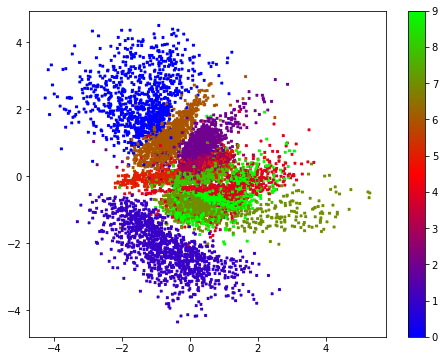

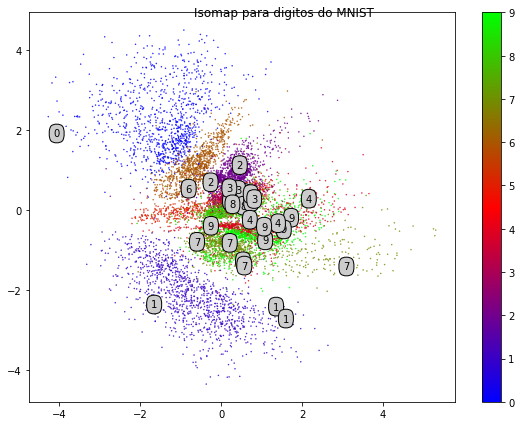

In [16]:
def plot_t_test(t_test,y_test):
    # grafico do latent vector t_test colorido pelos valores dos digitos nas imagens de input
    plt.figure(figsize=(8, 6))
    plt.scatter(t_test[:, 0], t_test[:, 1], marker='x', s=6.0, c=y_test,  cmap='brg')
    plt.colorbar();
    plt.show()

def plot2_t_test(t_test,y_test):   
    plt.figure(figsize=(8, 6))
    plt.scatter(t_test[:, 0], t_test[:, 1],s=0.2, c=y_test, cmap='brg')
    plt.colorbar();
    #plt.set_xticks(())
    #plt.set_yticks(())
    count=0;
    plt.tight_layout()
    plt.suptitle("Isomap para digitos do MNIST")
    for label , x, y in zip(y_test, t_test[:, 0], t_test[:, 1]):
    #anotar na imagem cada 1 em 300 amostras
      if count % 350 == 0:
        plt.annotate(str(int(label)),xy=(x,y), color='black', weight='normal',size=10,bbox=dict(boxstyle="round4,pad=.5", fc="0.8"))
      count = count + 1
    #plt.savefig("mnist_pca.png")
    plt.show()
 
    
#vae = load_model('model_vae_v1.h5') #não funciona pois o layers de sampling não é do keras
vae.load_weights('best_weights.hdf5')
# Generar os latent vectors dos test set
print("X_test:",X_test.shape)
tt_test = encoder.predict(X_test, batch_size=100)#[0]
t_mean_test=tt_test[0]
t_log_var_test=tt_test[1]
print("t_mean_test:",t_mean_test.shape)
print("t_log_var_test:",t_log_var_test.shape)
print("y_test:",y_test.shape)
print(y_test)
plot_t_test(t_mean_test,y_test)
plot2_t_test(t_mean_test,y_test)
#plot_t_test(t_log_var_test,y_test)

   grid_x     --      grid_y
 -1.644854  --    -1.644854
 -1.204047  --    -1.204047
 -0.920823  --    -0.920823
 -0.697141  --    -0.697141
 -0.503965  --    -0.503965
 -0.328072  --    -0.328072
 -0.161844  --    -0.161844
 -0.000000  --    -0.000000
 0.161844  --    0.161844
 0.328072  --    0.328072
 0.503965  --    0.503965
 0.697141  --    0.697141
 0.920823  --    0.920823
 1.204047  --    1.204047
 1.644854  --    1.644854


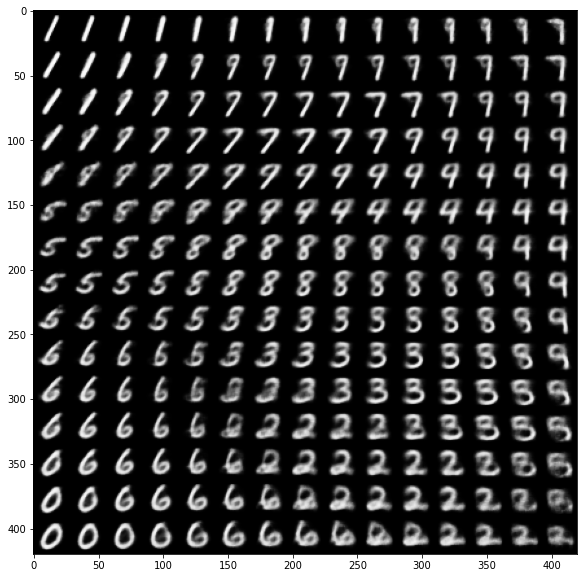

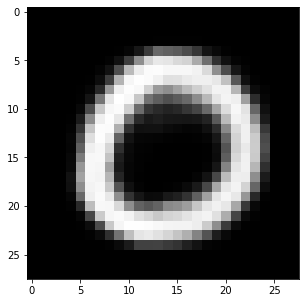

In [17]:
from scipy.stats import norm

def generate_images():
    # Numero de amostras por dimensão
    n = 15  
    batch_size=100
    # Construir uma matriz de valores para as latent variable
    # Amostras com intervalo de confiança de 90% da distribuição Gaussiana
    # com densidade de amostragem proporcional à densidade probabilistica
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #lista com n=15 elementos
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n)) #lista com n=15 elementos
    print("   grid_x     --      grid_y")
    for i in range(len(grid_x)):
        print(" %f  --    %f"%(grid_x[i],grid_y[i]))
    
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n)) #matriz para n=15*28 por n=15*28
    
    # fazer o decode para cada elemento da grelha
    for i, yi in enumerate(grid_x): #vai dar tuplos (0,-1.64485363e+00) (1,...)...
        for j, xi in enumerate(grid_y): #vai dar tuplos (0,-1.64485363e+00) (1,...)...
            t_amostra = np.array([[xi, yi]])
            t_amostra = np.tile(t_amostra, batch_size).reshape(batch_size, 2)
            t_decoded = decoder.predict(t_amostra, batch_size=100)
            digit = t_decoded[0].reshape(digit_size, digit_size)
            figure[i*digit_size:(i+1)*digit_size , j*digit_size:(j+1)*digit_size] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r');

def generate_digit(x,y):   
    digit_size = 28
    figure = np.zeros((digit_size, digit_size)) #matriz para n=15*28 por n=15*28
    amostra=np.array([[x, y]])
    t_decoded = decoder.predict(amostra)
    digit = t_decoded[0].reshape(digit_size, digit_size)
    plt.figure(figsize=(5, 5))
    plt.imshow(digit, cmap='Greys_r');    
    
generate_images()
generate_digit(-1,3)